In [5]:
import pymongo

db = pymongo.MongoClient('mongodb://127.0.0.1:27017')['radar']
col = db['release_metadata']
docs = col.find()

radar的metadata

- 思路1: metadata有优先级的, 前面的成功了就直接结束, 如果homepage, download_url这些匹配代码托管平台成功了, 就直接结束, 接着再看其他的code相关, 然后看bug相关, 最后看doc相关等等

- 思路2: 是根据分析结果调整metadata, badge等的权重, 粒度更细一些

- 并且可以定期统计, 动态调整 => 提高竞争力\卖点

[napari-svetlana](https://pypi.org/project/napari-svetlana/)以及[pubmed2pdf](https://pypi.org/project/pubmed2pdf/)的例子, Bug Tracker, User Support, Documentation也可以得到 ⇒ 直接在所有project_urls匹配得了?

首先需要对project_urls的field分布进行分析 => 还有哪些corner case? 还能有哪些好的field? 能不能试试性能不错的模糊匹配? 

In [6]:
project_url_field_counts = {}

for doc in docs:
    project_urls = doc["project_urls"]
    if isinstance(project_urls, dict):
        project_url_fields = project_urls.keys()
        for project_url_field in project_url_fields:
            if project_url_field in project_url_field_counts:
                project_url_field_counts[project_url_field] += 1
            else:
                project_url_field_counts[project_url_field] = 1
    
project_url_field_counts = sorted(project_url_field_counts.items(), key=lambda x: x[1], reverse=True)
project_url_field_counts = {item[0]: item[1] for item in project_url_field_counts}
print(project_url_field_counts)

[('Homepage', 3755887), ('Download', 776984), ('Source', 397808), ('Documentation', 357154), ('Tracker', 177702), ('Repository', 151007), ('Bug Tracker', 139382), ('Source Code', 53989), ('Bug Reports', 37055), ('Changelog', 25859), ('Issue tracker', 17006), ('Issues', 16066), ('Issue Tracker', 13794), ('Bug-Tracker', 12560), ('Funding', 12421), ('Source-Code', 12194), ('Code', 9356), ('GitHub', 8103), ('repository', 7926), ('Twitter', 6622), ('homepage', 6464), ('Contribute!', 6209), ('Forum', 6194), ('Say Thanks!', 5036), ('Home', 4795), ('documentation', 4524), ('Website', 4136), ('Discord', 4053), ('Source code', 3324), ('Changes', 3225), ('PyPI', 2942), ('Chat', 2652), ('CI', 2590), ('YouTube', 2436), ('Github', 2386), ('Docs', 2083), ('Blog', 1879), ('Slack Chat', 1845), ('Slack', 1778), ('Gitter', 1667), ('Discussions', 1643), ('issues', 1601), ('User Support', 1592), ('GitHub: repo', 1363), ('Releases', 1336), ('GitHub: issues', 1328), ('Dev Docs', 1324), ('Community', 1215), (

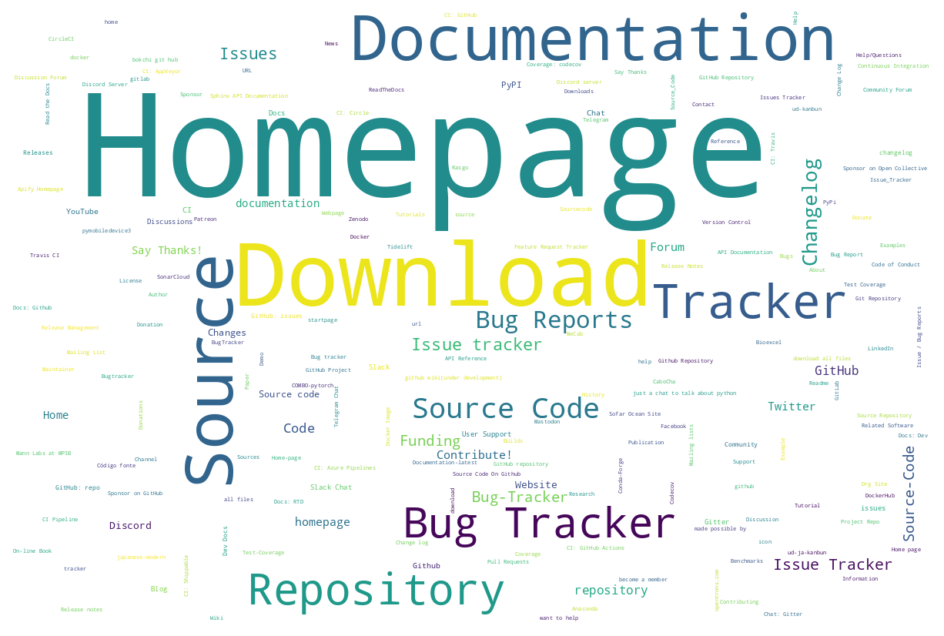

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=1200, height=800, background_color="white").generate_from_frequencies(project_url_field_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

bug tracker等field的url匹配包含代码托管平台关键词, 随机抽一部分, 人工看看结果如何, 排个优先级